# <p style="text-align: center;">CSC-514 Semester Project: License Plate Recognition</p>
## <p style="text-align: center;">Lane Moseley</p>
### <p style="text-align: center;">April 30, 2020</p>


## Introduction  
---

**The Project**  
  
The goal of this project is to develop a system of Python functions to read the license plate text from vehicles in still images. For this project we will only consider standard, rectangular European license plates, though the code could easily be adapted for other types of license plates. Generally, this involves three steps: *license plate detection*, *character segmentation*, and *character recognition*. Connected component analysis will be used to detect regions likely to contain license plates. Next, one of these regions will be selected as the region of choice by analyzing its gradient. Ideally, the region of choice will contain the license plate. Connected component analysis also provides a degree of character segmentation since it isolates the license plate from the rest of the image. For our current purposes, character recognition will be handled by Google's Tesseract-OCR (Optical Character Recognition) Engine.

**The Dataset**
* Images were selected from the following dataset: https://www.kaggle.com/pcmill/license-plates-on-vehicles
* Images were chosen on the basis of
    * containing a passenger vehicle with a European-style rectangular license plate
    * containing only one visible license plate
    * the license plate not being damaged or partially obscured
    * the background not being excessively noisy
    * the license plate being at a reasonable angle within the image

**Supporting Literature:**
* [License Plate Recognition Using OpenCV, Yolo, and Keras](https://medium.com/@theophilebuyssens/license-plate-recognition-using-opencv-yolo-and-keras-f5bfe03afc65), Medium.com
* [License Plate Recognition Using Raspberry Pi and OpenCV](https://circuitdigest.com/microcontroller-projects/license-plate-recognition-using-raspberry-pi-and-opencv), Circuit Digest
* [Developing A License Plate Recognition System With Machine Learning In Python](https://blog.devcenter.co/developing-a-license-plate-recognition-system-with-machine-learning-in-python-787833569ccd), Devcenter Square


## Procedure
---

### Imports, Constants, and Helper Functions  
As noted in the code below, we will be using Google's Tesseract-OCR (Optical Character Recognition) Engine.  
**Pytesseract can be installed as follows:**
1. *Install tesseract*
    * Linux: `sudo apt-get install tesseract-ocr`
    * Mac: `brew install tesseract`
2. *Install pytesseract (make sure to activate the correct conda environment beforehand)*
    * `pip install pytesseract`
3. *Get the path to the tesseract executable*
    * `which tesseract`
4. *Copy and paste the following below the `import pytesseract` statement*
    * `pytesseract.pytesseract.tesseract_cmd = <path generated in the previous step>`

In [1]:
# IMPORTS #
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import measure
from skimage.filters import threshold_otsu
from skimage.measure import regionprops

# We will be using Google's Tesseract-OCR (Optical Character Recognition) Engine.
# To get pytesseract working, install tesseract:
#    Linux: sudo apt-get install tesseract-ocr
#    Mac:   brew install tesseract
# Install pytesseract:
#    pip install pytesseract
# Get the path to the tesseract executable:
#    which tesseract
# Copy and paste that path below.
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/local/bin/tesseract'


# FIGURE SIZE #
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['figure.dpi'] = 80


# HELPER FUNCTIONS #
def binarize_image(img, threshold_value=None):
    """
    Helper function to convert an image to binary.
    :param img: image
    :param threshold_value: threshold used for conversion
    :return: resulting image
    """
    # unless a threshold value is specified, use Otsu's method
    # for automatic image thresholding
    if threshold_value is None:
        threshold_value = threshold_otsu(img)
    b_img = img > threshold_value

    # the resulting image matrix will have values that are either
    # True or False, so we convert those values to either 0 or 255
    return np.uint8(b_img * 255)


def show_result(img, sub_img, coords, title):
    """
    Helper function to display an image with a smaller image as an inset.
    :param img: image to display
    :param sub_img: image to display in the inset
    :param coords: the coordinates of the inset, used for drawing the border
    :param title: title of the plot
    :return: None
    """
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.imshow(img)
    min_row, min_col, max_row, max_col = coords
    rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red", linewidth=2, fill=False)
    ax.add_patch(rectBorder)

    # build the inset
    axins = ax.inset_axes([0.52, 0.6, 0.47, 0.47])
    axins.imshow(sub_img, cmap='gray')
    axins.axis(False)

    plt.title(title, fontsize=15)
    plt.axis(False)
    plt.show()

### Plate Detection and Character Segmentation

The following function will use *connected component analysis* to identify regions in the image where the license plate is likely located. As noted in the code, the regions that we want to consider are limited to regions with sizes that maintain the height and width ratios characteristic of standard, rectangular European license plates.  
  
Connected component analysis also provides a small degree of character segmentation since it isolates the license plate from the rest of the image. In order to provide better character segmentation the image of the region could be de-skewed and a 'second crop' could be performed. Additionally, the individual characters could be isolated and placed in separate images. Since we're using Pytesseract for character recognition we don't necessarily need to segment the characters individually, though we should still do our best to make the text easier for Pytesseract to read.

In [2]:
def get_regions(b_img, g_img, show_res=False):
    """
    This function will find areas within an image that are likely to contain
    a license plate.
    :param b_img: binary image
    :param g_img: grayscale image
    :param show_res: if True, show the connected image
    :return: list of regions, list of region coordinates
    """
    # group together all of the connected regions in the binary image
    c_img = measure.label(b_img)

    if show_res:
        plt.imshow(c_img, cmap='gray')
        plt.axis(False)
        plt.title("Resulting Image After Grouping Connected Regions")
        plt.show()

    # find the maximum dimensions the license plate could be
    # this is tuned for european plates, which are typically 20.5 inches wide and 4.5 inches tall, so
    # the proportion of the width of the license plate region to the full license plate region is around 22% (we use 17% -> 27%)
    # the proportion of the height of the license plate region to the full license plate region is around 5% (we use 1% -> 10%)
    max_dims = (0.01 * c_img.shape[0], 0.1 * c_img.shape[0], 0.17 * c_img.shape[1], 0.27 * c_img.shape[1])
    min_height, max_height, min_width, max_width = max_dims

    regions = []
    region_coords = []

    # iterate through the list of labelled regions
    for region in regionprops(c_img):
        if region.area < 150:
            # the region is too small to be a license plate
            continue

        # the bounding box coordinates of the region
        y1, x1, y2, x2 = region.bbox
        height = y2 - y1
        width = x2 - x1
        
        if height >= min_height and height <= max_height and width >= min_width and width <= max_width and width > height:
            regions.append(g_img[y1:y2, x1:x2])
            region_coords.append((y1, x1, y2, x2))

    return regions, region_coords


The previous function returns a list of regions that may or may not contain a license plate. Some of the regions may contain things like headlights, bumper stickers, reflections from the windshield, and so on. The job of this next function is to decide which region actually contains the license plate. It does this by analyzing the x and y gradient images of each region. Regions containing text tend to have lots of sharp, high-contrast edges. By comparing the norms of the gradient images for each region we can find the region containing the license plate.

In [3]:
def identify_plate(regions, region_coords, show_res=False):
    """
    Select the license plate from a list of regions possibly containing license plates.
    :param regions: list of regions
    :param region_coords: list of coordinates for the regions
    :param show_res: if True, show plots
    :return: selected_region, selected_region_coordinates
    """
    # There will likely be multiple regions, but only one of the regions will be the license plate.
    # The others are going to be things like headlights, reflections from the windshield, decals, etc.
    # In order to find the correct region we are going to look at the gradients of each region.
    # The correct region will have the highest frequency of abrupt, sharp changes.
    norms = []
    for i, region in enumerate(regions):
        gx = cv2.Sobel(region, cv2.CV_32F, 1, 0, ksize=1)
        gy = cv2.Sobel(region, cv2.CV_32F, 0, 1, ksize=1)
        norms.append(np.linalg.norm(gx) + np.linalg.norm(gy))

        if show_res:
            fig, ax = plt.subplots(1, 3)
            ax[0].set_title("Region of Consideration")
            ax[0].imshow(region, cmap='gray')
            ax[0].axis(False)
            
            ax[1].set_title("Histogram of $\mathbb{G}_X$")
            ax[1].hist(gx.ravel())
            ax[1].set_xlabel("Gradient")
            ax[1].set_ylabel("Frequency")

            ax[2].set_title("Histogram of $\mathbb{G}_Y$")
            ax[2].hist(gy.ravel())
            ax[2].set_xlabel("Gradient")
            ax[2].set_ylabel("Frequency")

            plt.show()

    index = norms.index(max(norms))
    selected_region = regions[index]
    selected_region = binarize_image(selected_region)

    return selected_region, region_coords[index]

### Character Recognition

I had originally intended to develop my own system for optical character recognition using principal component analysis, however; due to time constraints I chose to use Pytesseract to handle optical character recognition. Installation and integration of Pytesseract is covered at the beginning of this document.

In [4]:
def read_image(img):
    """
    A function that will read the text in an image and return the result.
    This currently uses Tesseract-OCR.
    :param img: image 
    :return: the String of text found in the image
    """
    text = pytesseract.image_to_string(img, lang='eng', config='--psm 13')

    if text == "":
        return "None"

    return text


### Putting It All Together

This last function is the user-facing function for the program. It allows the user to specify an image for analysis, runs the analysis, and outputs the results.

In [5]:
def read_license_plate(img, img_name, show_res=True):
    """
    This function will attempt to find and read the license plate within the image.
    :param img: image
    :param img_name: name of image
    :param show_res: if True, show all plots
    :return: None
    """
    g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    g_img = cv2.bilateralFilter(g_img, 11, 17, 17)
    b_img = binarize_image(g_img)

    if show_res:
        fig, ax = plt.subplots(1, 3)
        [ax[i].axis(False) for i in range(3)]

        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[0].set_title("Original Image")
        ax[1].imshow(g_img, cmap='gray')
        ax[1].set_title("Filtered Grayscale Image")
        ax[2].imshow(b_img, cmap='gray')
        ax[2].set_title("Binary Image")

        plt.show()

    # find the license plate
    objs, coords = get_regions(b_img, g_img, show_res=show_res)

    # if no plate was found, just exit
    if len(objs) < 1 or coords is None:
        print(img_name + ": No plate detected.")
        return

    if show_res:
        fig, ax = plt.subplots(1)
        ax.imshow(g_img, cmap='gray')

        for i in range(len(coords)):
            y1, x1, y2, x2 = coords[i]
            rectBorder = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor="red", linewidth=2, fill=False)
            ax.add_patch(rectBorder)

        plt.title("Detected Regions")
        plt.axis(False)
        plt.show()

    # crop out the number plate
    selected_region, region_coords = identify_plate(objs, coords, show_res)

    # Read the number plate
    text = read_image(selected_region)
    show_result(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), selected_region, region_coords, "Image: " + img_name + "\nDetected: " + text)

### Notable Successes

**img_65**

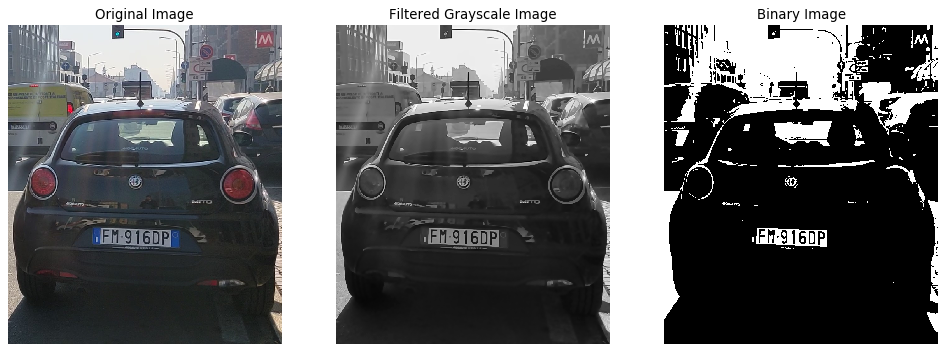

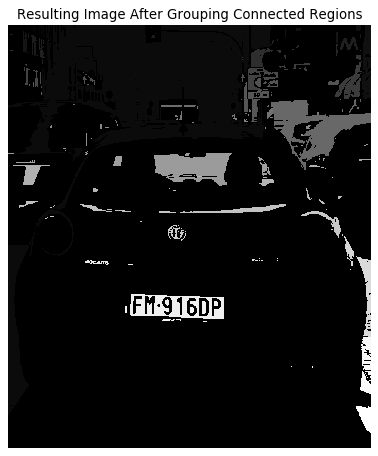

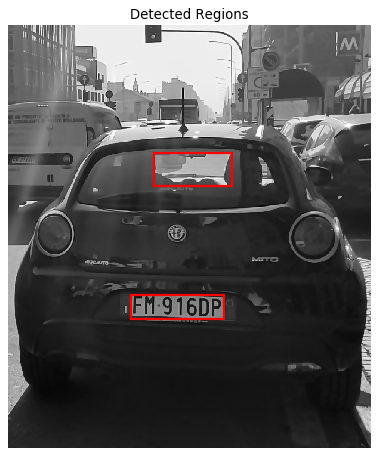

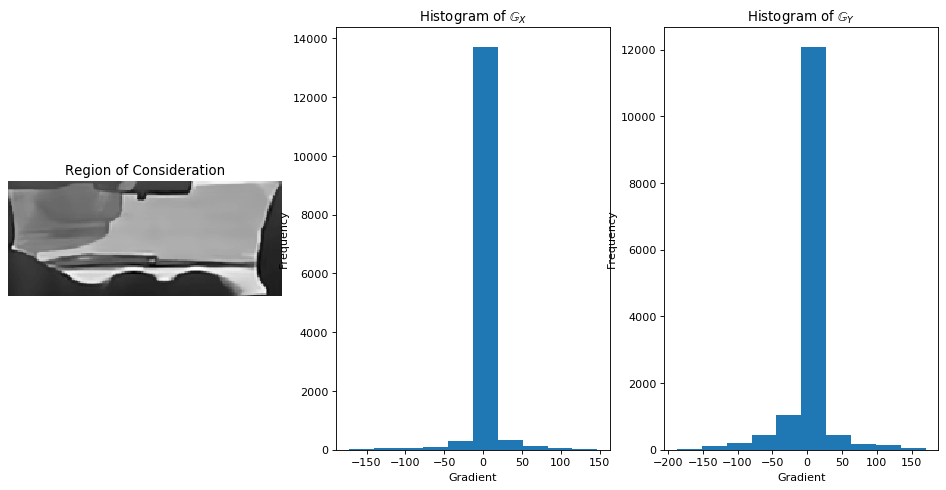

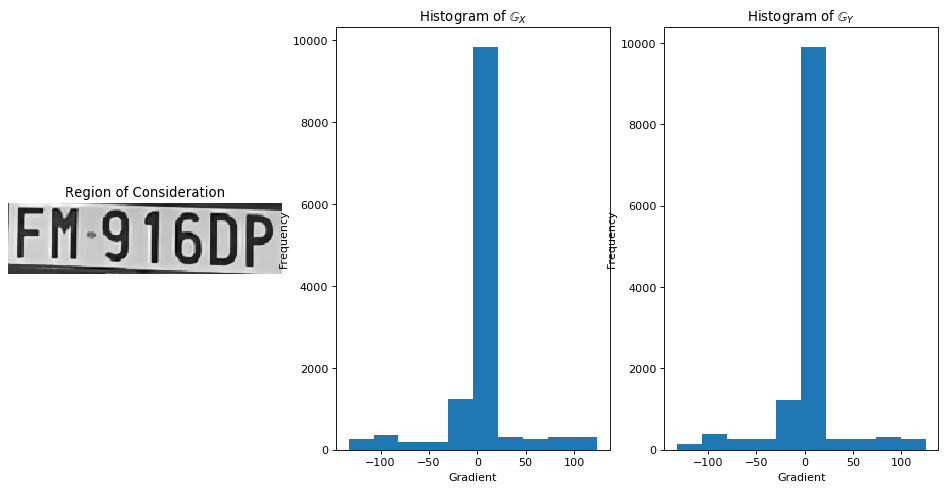

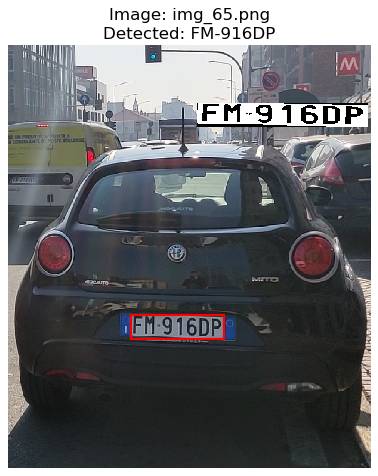

In [6]:
img_name = "img_65.png"
img = cv2.imread("vehicle_images/" + img_name, cv2.IMREAD_COLOR)
read_license_plate(img, img_name, True)


**img_63**

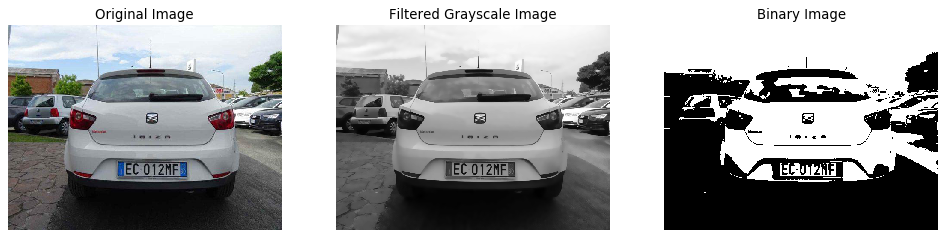

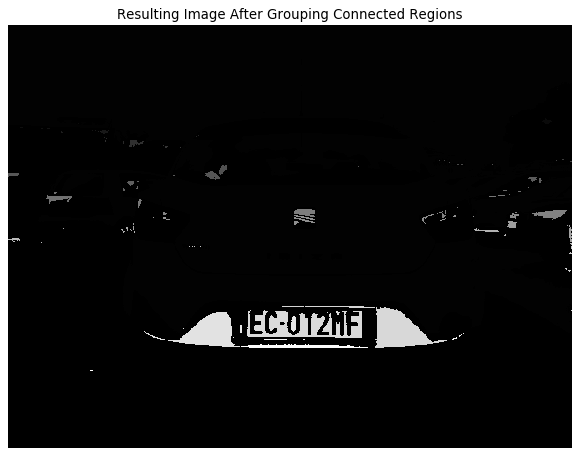

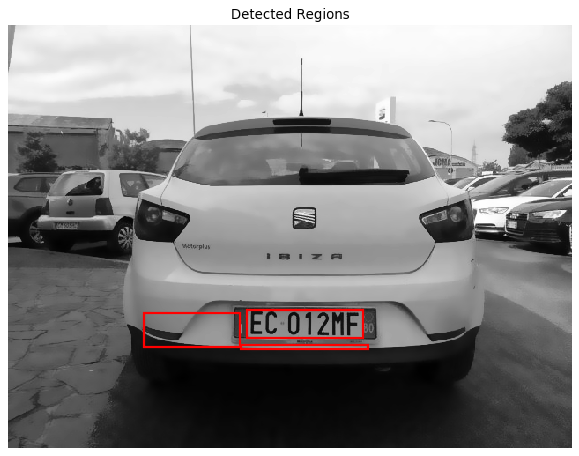

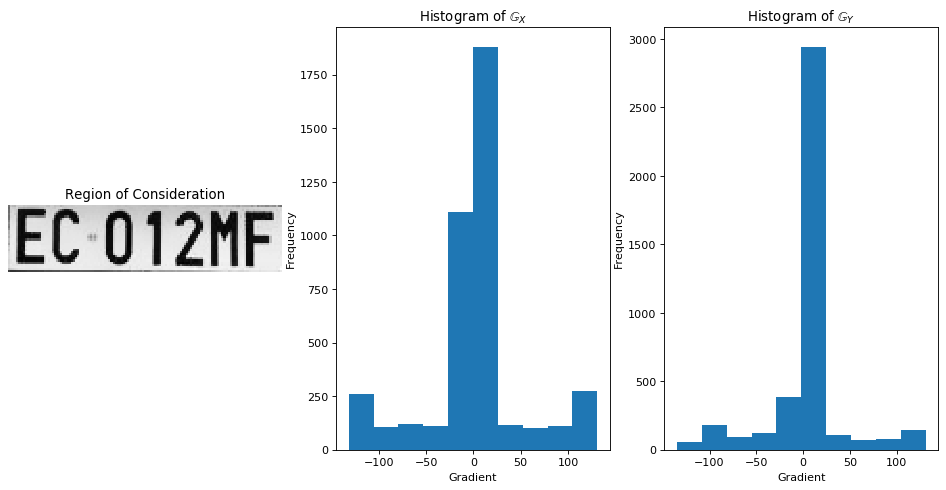

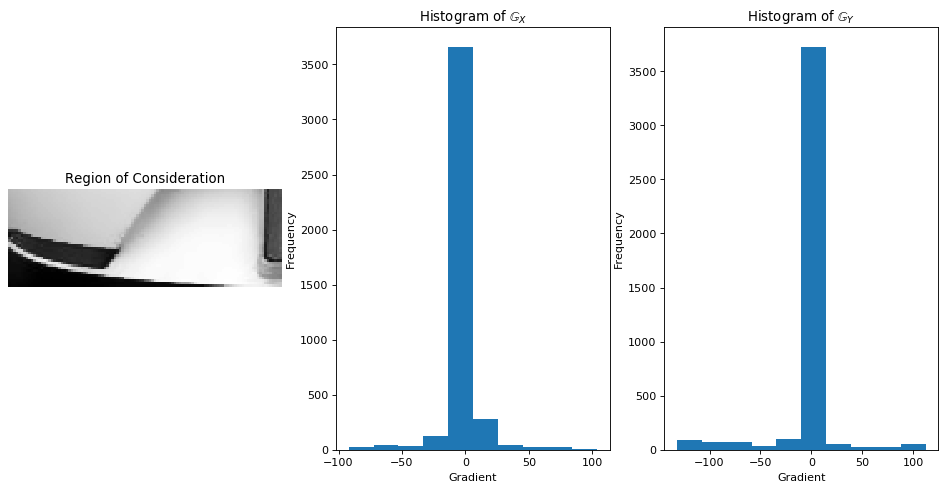

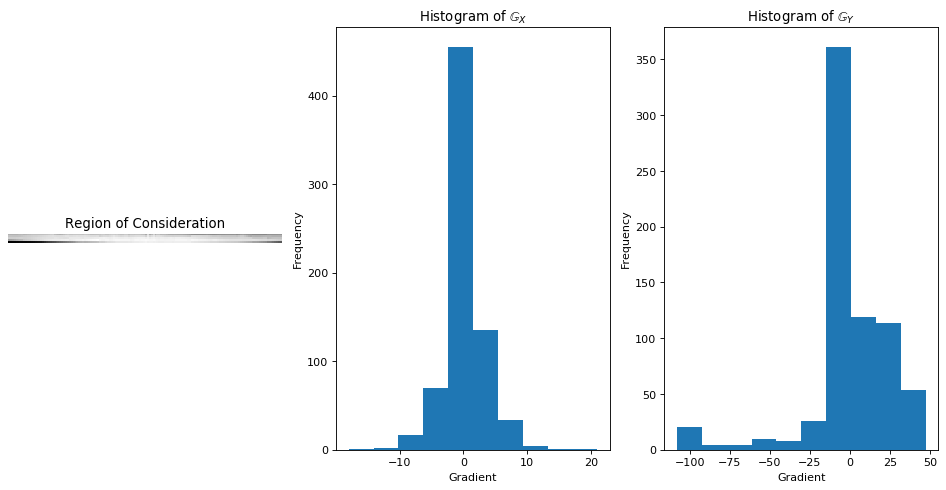

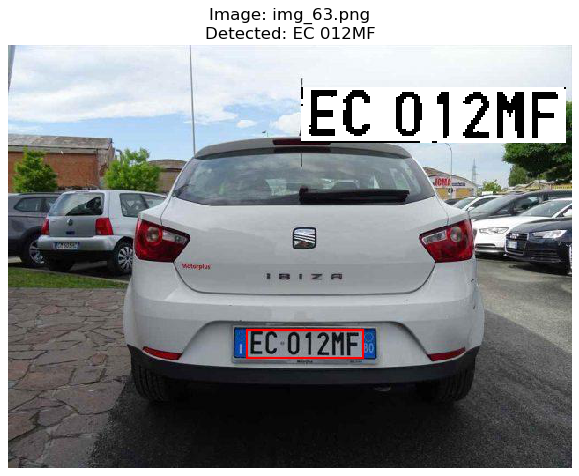

In [7]:
img_name = "img_63.png"
img = cv2.imread("vehicle_images/" + img_name, cv2.IMREAD_COLOR)
read_license_plate(img, img_name, True)


**img_18**

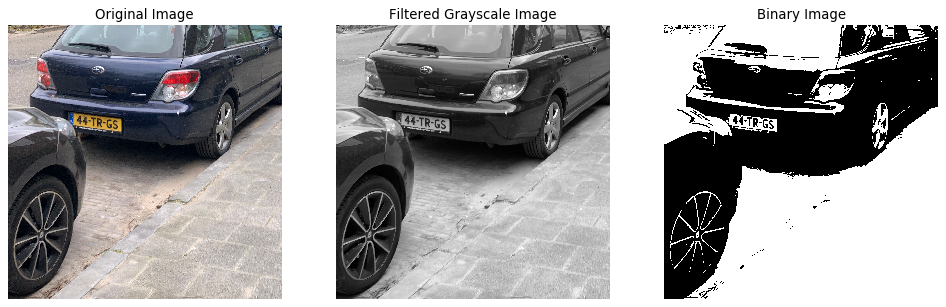

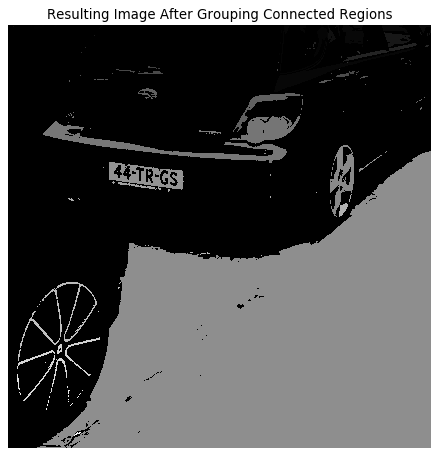

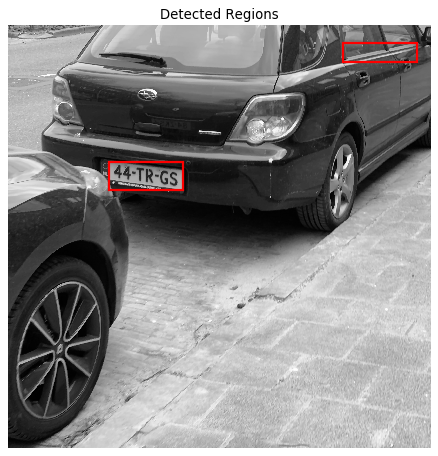

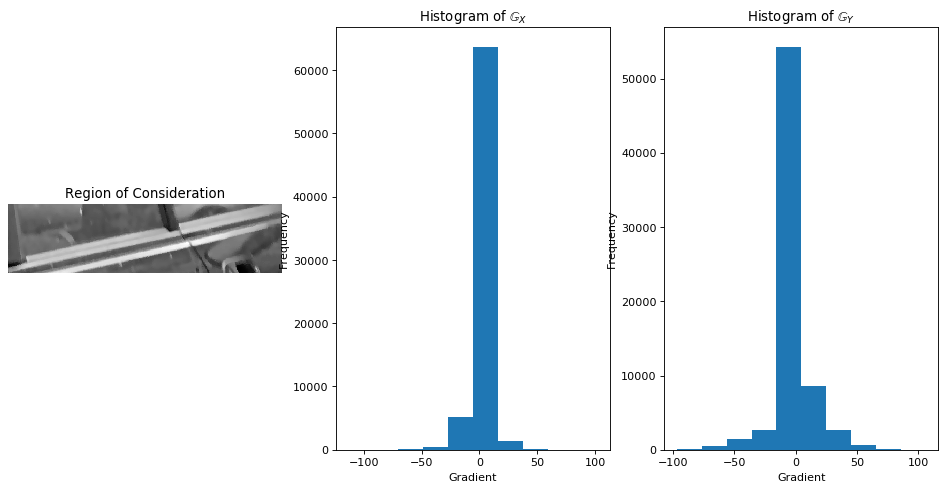

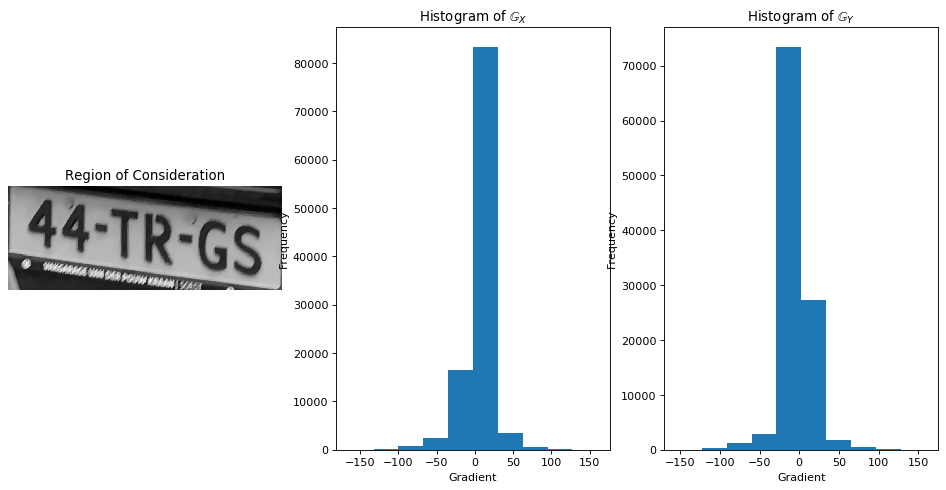

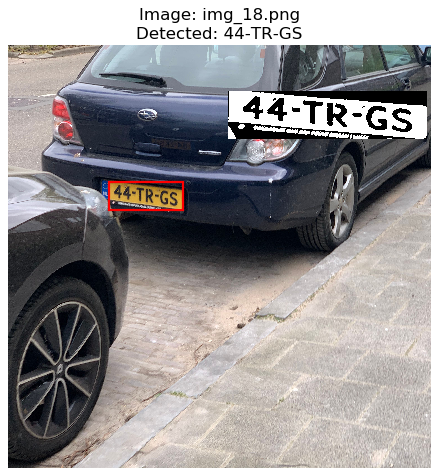

In [8]:
img_name = "img_18.png"
img = cv2.imread("vehicle_images/" + img_name, cv2.IMREAD_COLOR)
read_license_plate(img, img_name, True)


### Notable Failures

**img_3: license plate not detected**  
Notice how noisy the cobblestone street is. While the license plate is distinctly visible in the binary image, connected component analysis fails to distinguish the license plate from its surroundings. The license plate just gets lost in the noise. 

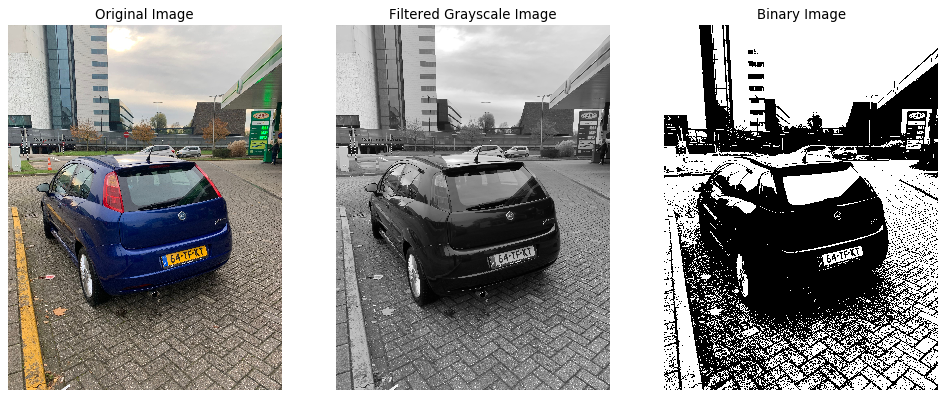

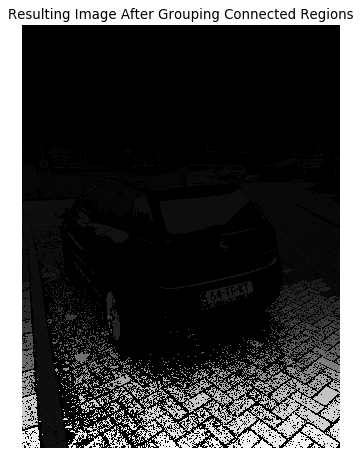

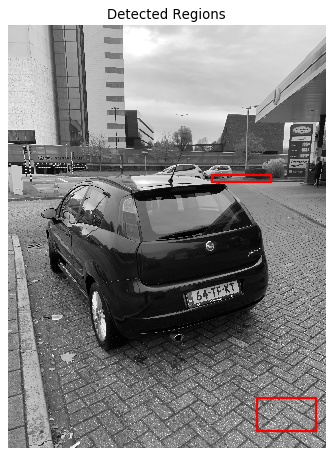

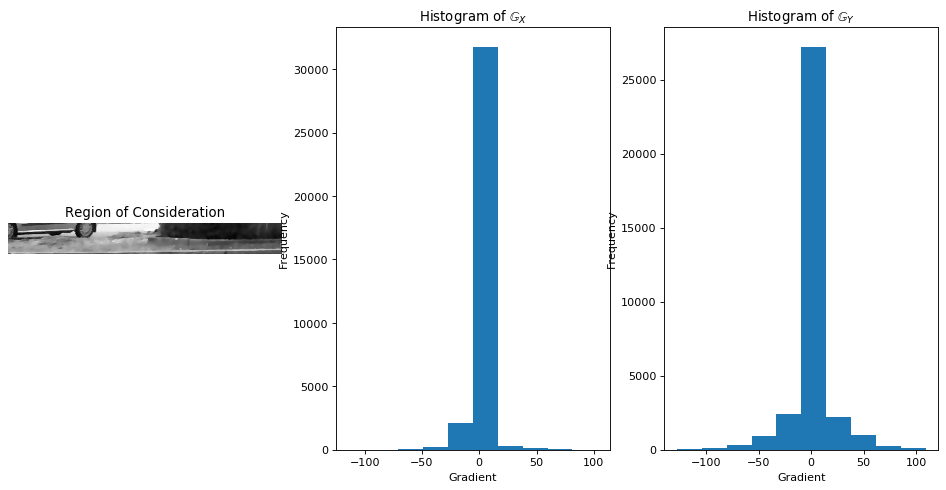

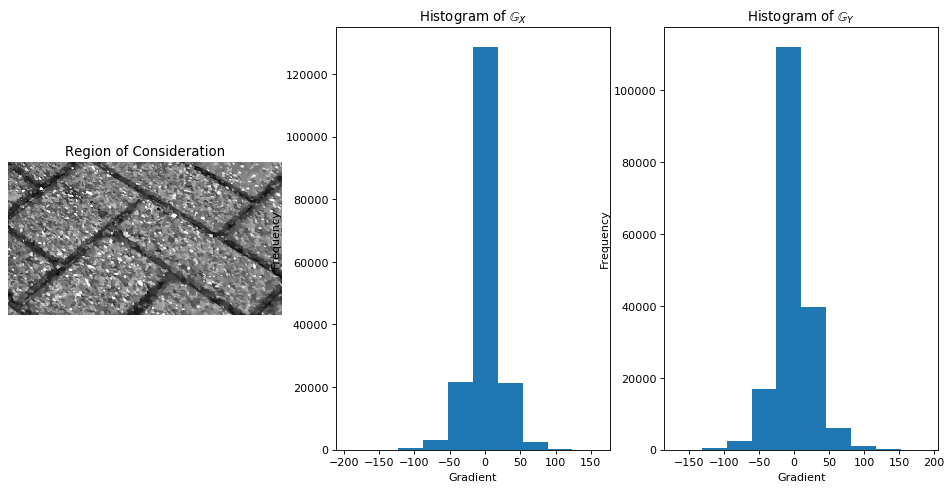

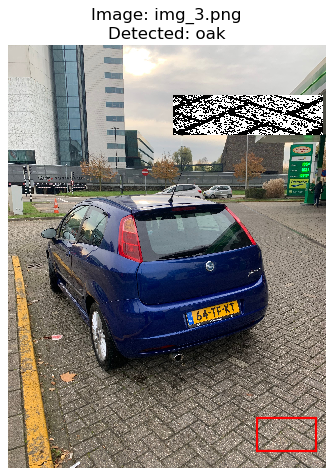

In [9]:
img_name = "img_3.png"
img = cv2.imread("vehicle_images/" + img_name, cv2.IMREAD_COLOR)
read_license_plate(img, img_name, True)


**img_44: license plate text is incorrect**  
The license plate was successfully found, but the text is incorrect. If you look at the license plate region, you'll see that the text is clearly visible, but significantly skewed. De-skewing the license plate region before using Pytesseract to parse the text would likely solve this problem.

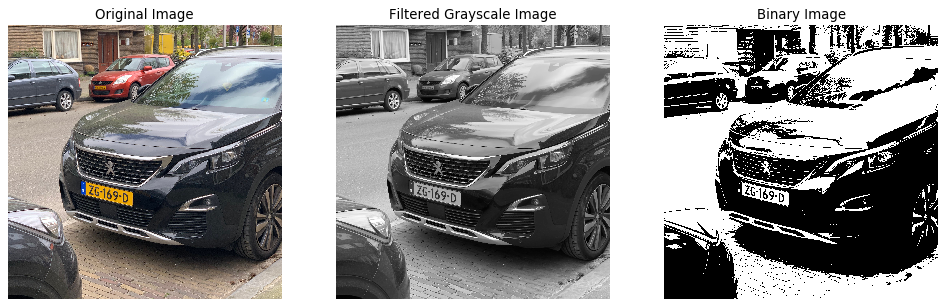

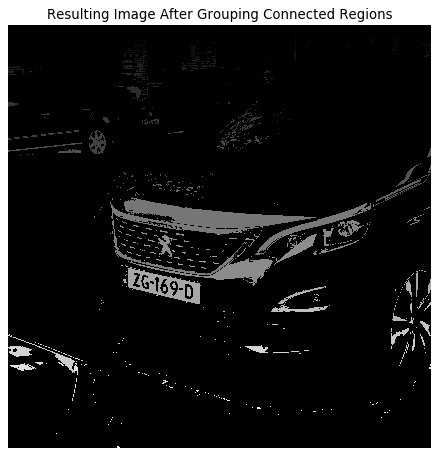

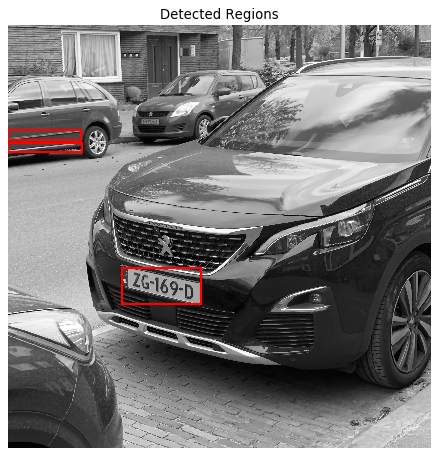

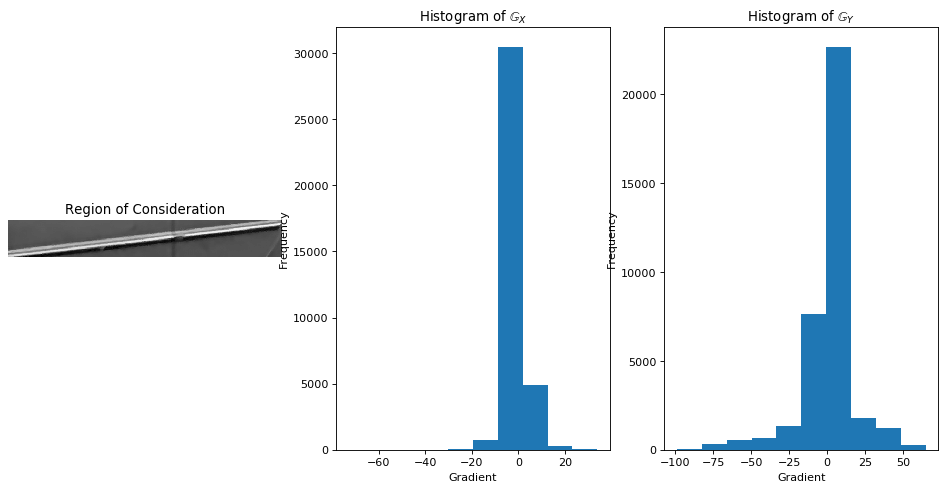

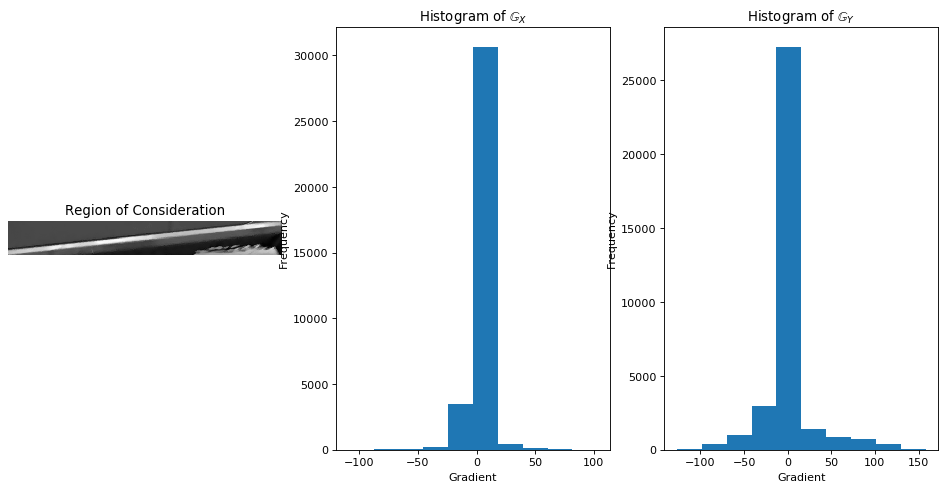

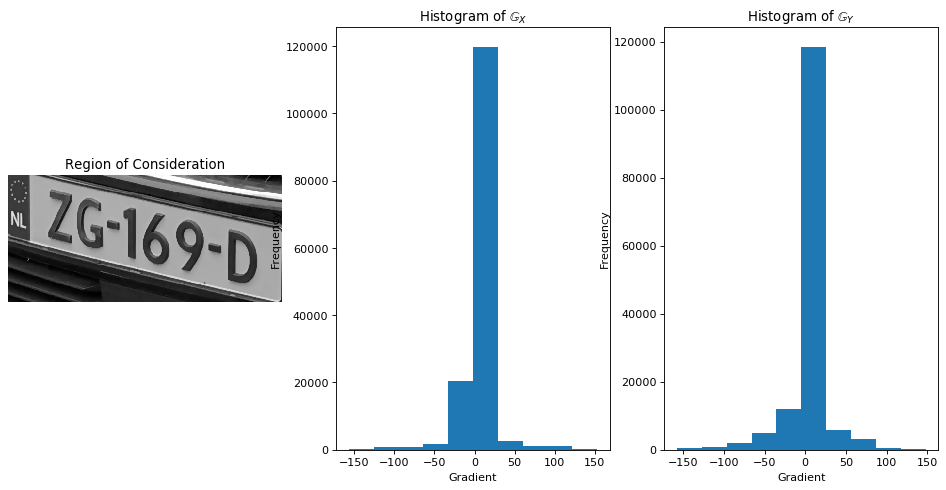

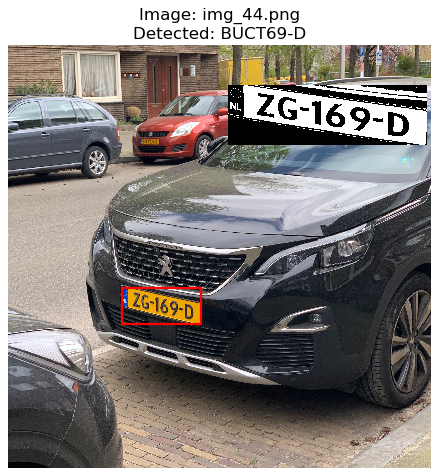

In [10]:
img_name = "img_44.png"
img = cv2.imread("vehicle_images/" + img_name, cv2.IMREAD_COLOR)
read_license_plate(img, img_name, True)


**img_39: license plate text is incorrect**  
This is an interesting case. This is one of the only photos in the data set with two clearly visible license plates. Like the previous example failure, the license plate was successfully found (the one on the van), but the text is incorrect. This time, though, the text is not skewed, so why wasn't Pytesseract able to parse the correct text from the image? This image is difficult for Pytesseract to parse text from because of the wide border surrounding the text. Performing a 'second crop' on the license plate region would likely solve the problem.

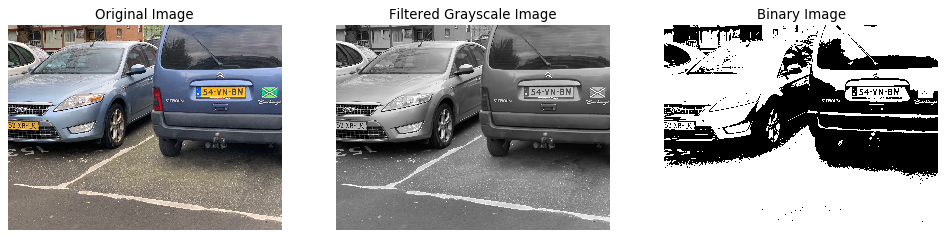

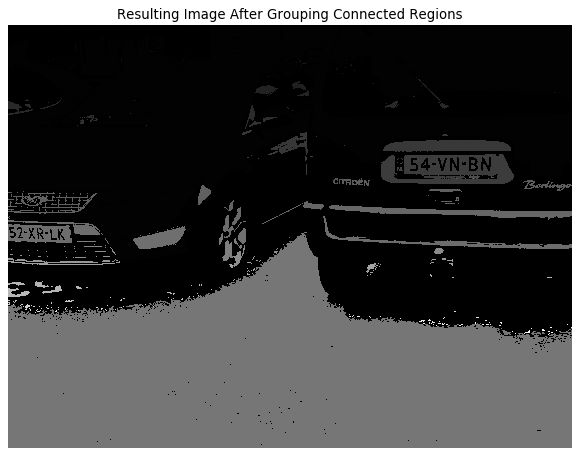

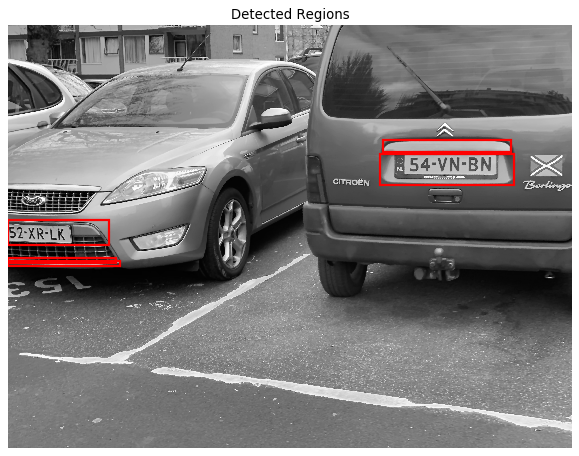

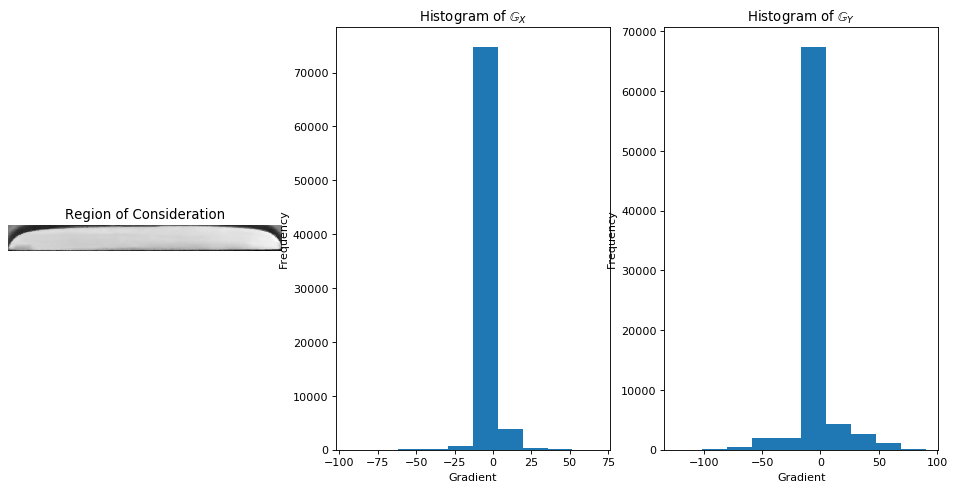

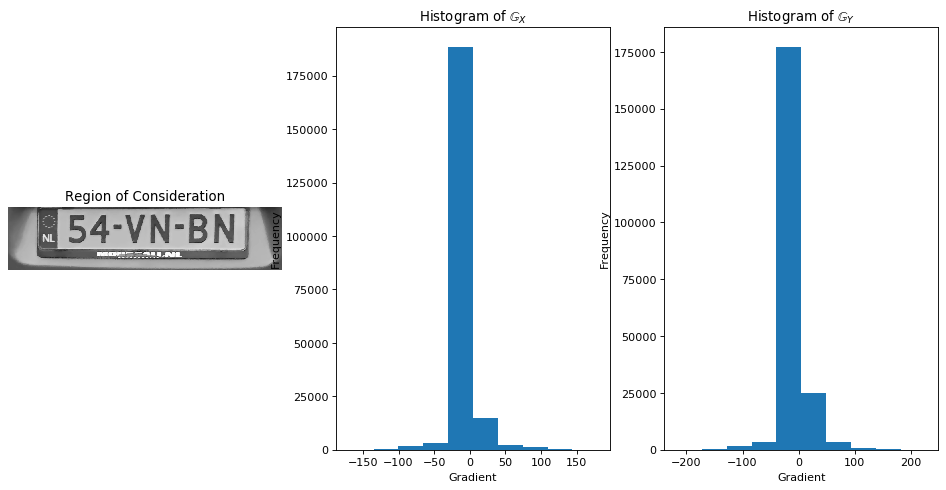

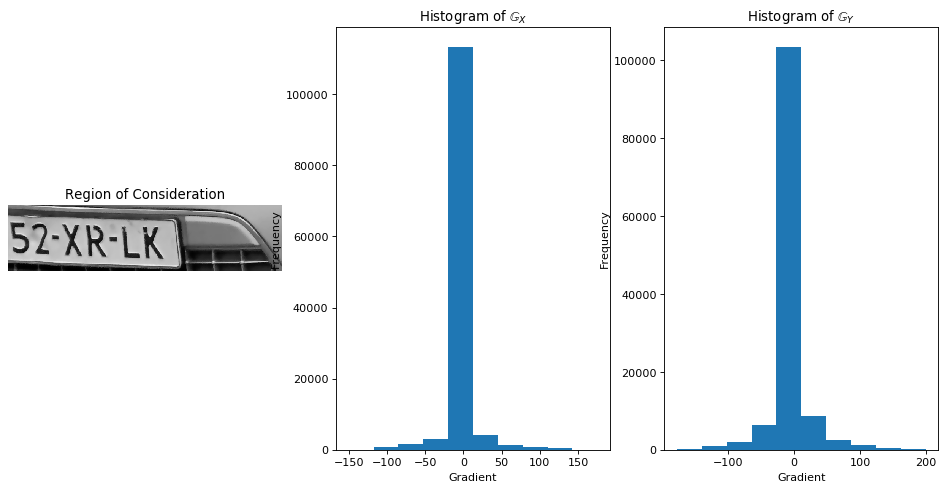

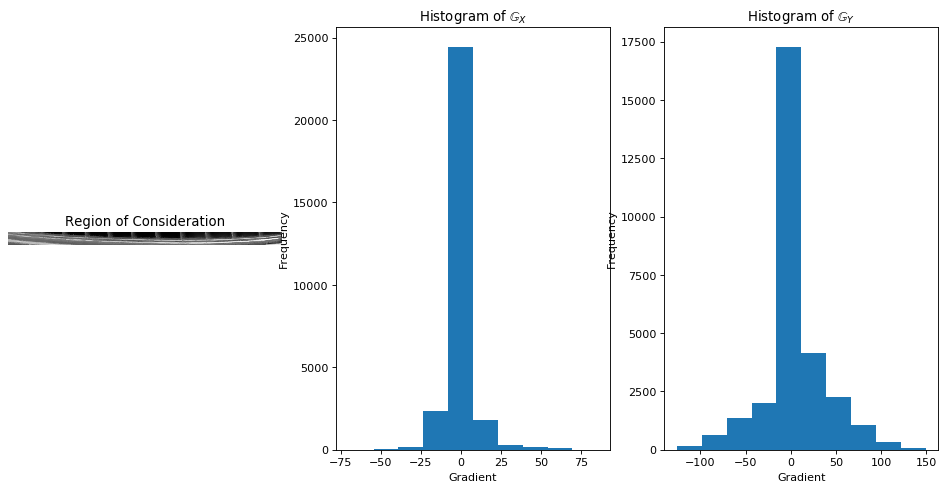

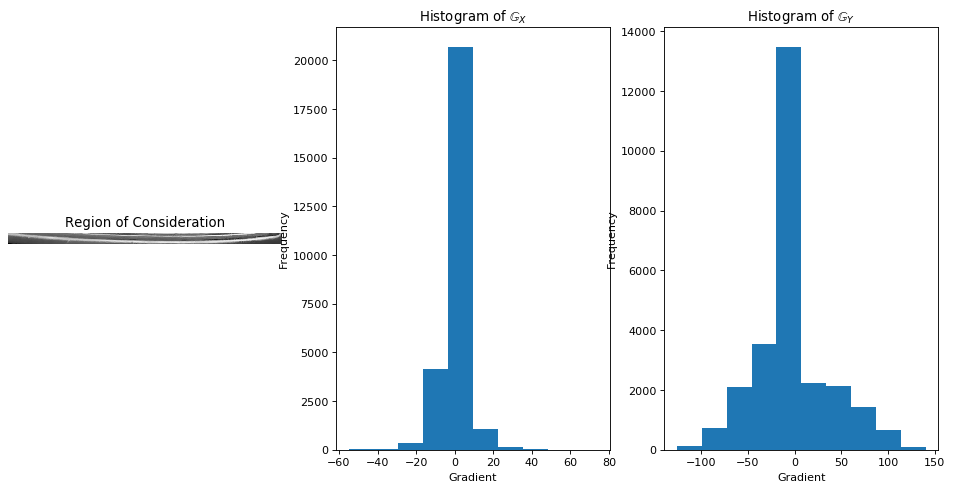

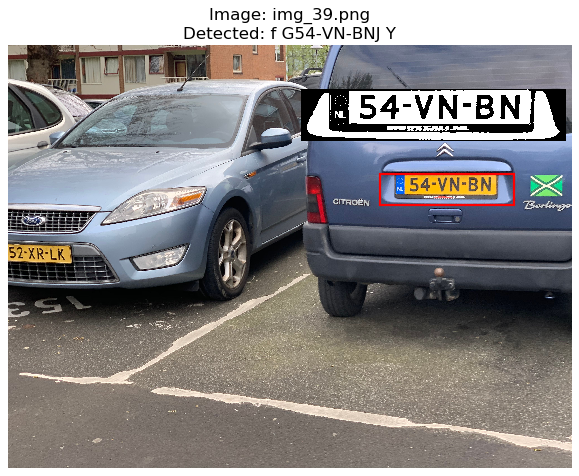

In [11]:
img_name = "img_39.png"
img = cv2.imread("vehicle_images/" + img_name, cv2.IMREAD_COLOR)
read_license_plate(img, img_name, True)


## Conclusion
---

The license plate recognition system outlined above works well on images where the license plate is clearly visible, the camera is not angled, and the camera is facing the license plate directly. Noisy backgrounds, shadows, partially obscured license plates, and large camera angles cause the system to report inaccurate results. Recommended improvements would include using machine learning instead of connected component analysis to detect license plates, de-skewing license plate images, and performing a 'second crop' on license plate images.